#  **House Price Prediction**

> This tutorial is to explain certain essential data science practices to improve Machine Learning Predictions

In [86]:
# This cell imports all the necessary libraries and methods
import pandas as pd
import numpy as np

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
# Read the data
train_data = pd.read_csv('datasets/train.csv', index_col='Id')
X_test = pd.read_csv('datasets/test.csv', index_col='Id')

In [88]:
# Separate features from labels
y = train_data.SalePrice              
X_train = train_data.drop(['SalePrice'], axis=1)

## Feature Analysis

**First look for suitable features which are strongly correlated with SalePrice**

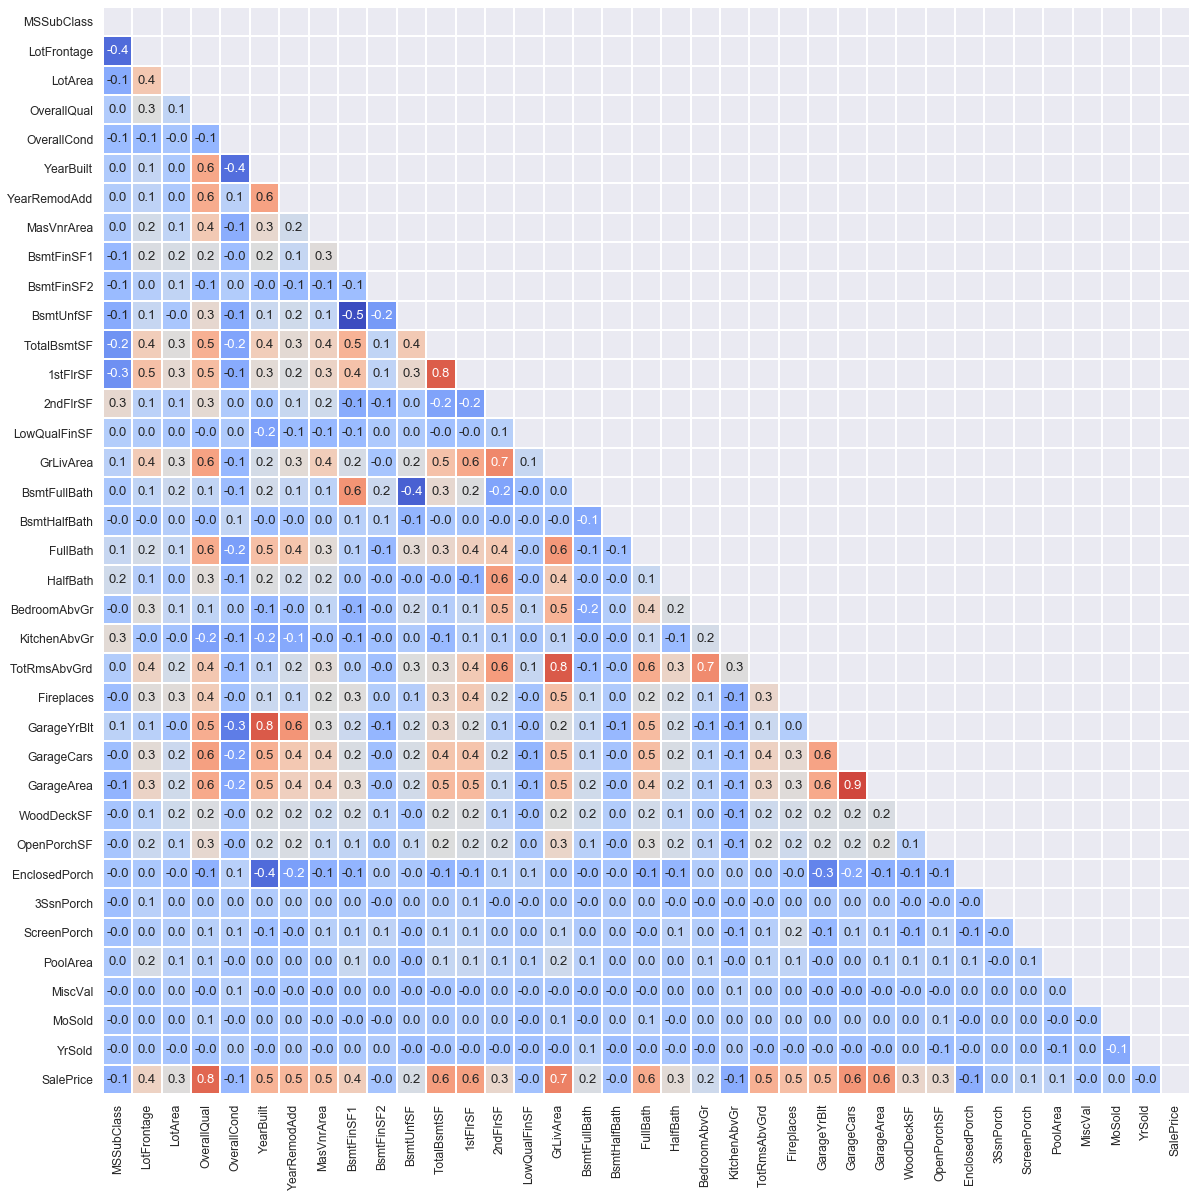

In [89]:
# Correlation analysis
correlation_df = train_data.corr()

# Set font_scale
sns.set(font_scale=1.1)

# Set plot size
plt.figure(figsize=(20, 20))

# Define a mask to show only the upper triangular matrix of the correlation matrix
mask = np.triu(correlation_df.corr())

# Use a heatmap to analyse correlation
sns.heatmap(correlation_df,
            fmt='.1f',
            annot=True,
            cmap="coolwarm",
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)


# Show plot as a diagram rather than an object
plt.show()

In [90]:
# Concatenate features from both testing and training datasets
features = pd.concat([X_train, X_test]).reset_index(drop=True)
print(features.shape)

(2919, 79)


In [91]:
def missing_percentage(df):
    '''Return the number and percentage of missing values'''
    NaN_count = df.isnull().sum().sort_values(ascending=False)
    NaN_count = NaN_count[NaN_count!=0]
    
    NaN_percent = (NaN_count / len(df)) * 100
    
    NaN_info = pd.concat([NaN_count, NaN_percent], axis=1, keys=["Total", "Percent"])
    
    return NaN_info

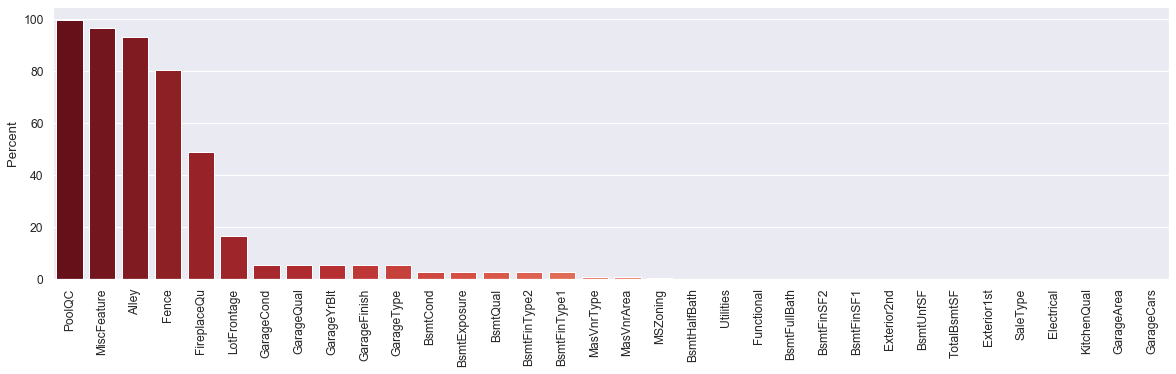

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageCond,GarageQual,GarageYrBlt,GarageFinish,GarageType,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType2,BsmtFinType1,MasVnrType,MasVnrArea,MSZoning,BsmtHalfBath,Utilities,Functional,BsmtFullBath,BsmtFinSF2,BsmtFinSF1,Exterior2nd,BsmtUnfSF,TotalBsmtSF,Exterior1st,SaleType,Electrical,KitchenQual,GarageArea,GarageCars
Total,2909.000000,2814.000000,2721.000000,2348.000000,1420.000000,486.000000,159.000000,159.000000,159.000000,159.000000,157.000000,82.000000,82.000000,81.000000,80.000000,79.000000,24.000000,23.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Percent,99.657417,96.402878,93.216855,80.438506,48.646797,16.649538,5.447071,5.447071,5.447071,5.447071,5.378554,2.809181,2.809181,2.774923,2.740665,2.706406,0.822199,0.787941,0.137033,0.068517,0.068517,0.068517,0.068517,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258


In [92]:
missing = missing_percentage(features)

fig, ax = plt.subplots(figsize=(20, 5))

sns.barplot(x=missing.index, y="Percent", data=missing, palette="Reds_r")
plt.xticks(rotation="vertical")

plt.show()

missing = missing.T

display(missing.style.background_gradient(cmap="Reds", axis=1))

In [93]:
# Let't categorize the missing the features
# Some null values 
zero_cols = [col for col in missing.columns if (X_train[col].dtype!="O" and col!="LotFrontage")]
freq_cols = [col for col in missing.columns if (missing[col]["Total"]<=2 and col not in zero_cols)]
none_cols = [col for col in missing.columns if (X_train[col].dtype=="O" and col!="MSZoning")]


# Some N/A values mean that a particular house doesn't have the feature described (eg; A pool, an alley)
# In such cases, numerical values will be marked as 0 and categorical features will be categorized by a new class, None
# In cases where the null values occur in a few houses, it is possible that there're actual missing values
# In such cases, we will replace them with the mode

for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)
    
for col in freq_cols:
    features[col].replace(np.nan, features[col].mode()[0], inplace=True)
    
for col in none_cols:
    features[col].replace(np.nan, "None", inplace=True)

In [94]:
# We can't replace all NaN values in the MSSubClass and LotFrontage
# with zeros (O can't be a reasonable prediction of the null values)
# We can use other features to make a fairly accurate estimation of the null values

# I can modularise this part by creating a function called strategic_imputation

# MSSubClass (the type of dwelling) may help predict the type of zone
features["MSZoning"] = features.groupby("MSSubClass")["MSZoning"].apply(lambda x:x.fillna(x.mode()[0]))

# Neighbourhood may help predict the LotFrontage
features["LotFrontage"] = features.groupby("Neighborhood")["LotFrontage"].apply(lambda x:x.fillna(x.median()))

In [95]:
# We must cast some features from numerical features to strings
# One example is the year sold, "YrSold": the model may look for unneccessary patterns between the size of the year
# as a number rather than considering it as a category

numerical_to_categorical = ["MSSubClass", "YrSold", "MoSold"]

for feature in numerical_to_categorical:
    features[feature] = features[feature].astype("str")

#   Feature Engineering

In [96]:
# Some features have some values which are less than 10
# If a feature has two or more of such values, we will place it the other list
# Then, we will classify those mini values together as Other' 

others = [feature for feature in features.columns if ((features[feature].value_counts()<10).sum() > 1) and (features[feature].dtype=="O")]

for col in others:
    indices = features[col].isin(features[col].value_counts()[features[col].value_counts()<10].index)
    features[col][indices] = "Other"

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':



# Categorical Data

In [97]:
from matplotlib.ticker import MaxNLocator

def srt_box(y, df):
    
    '''A function for displaying categorical variables.'''
    
    fig, axes = plt.subplots(14, 3, figsize=(25, 80))
    axes = axes.flatten()
    
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    for i, j in zip(categorical_columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

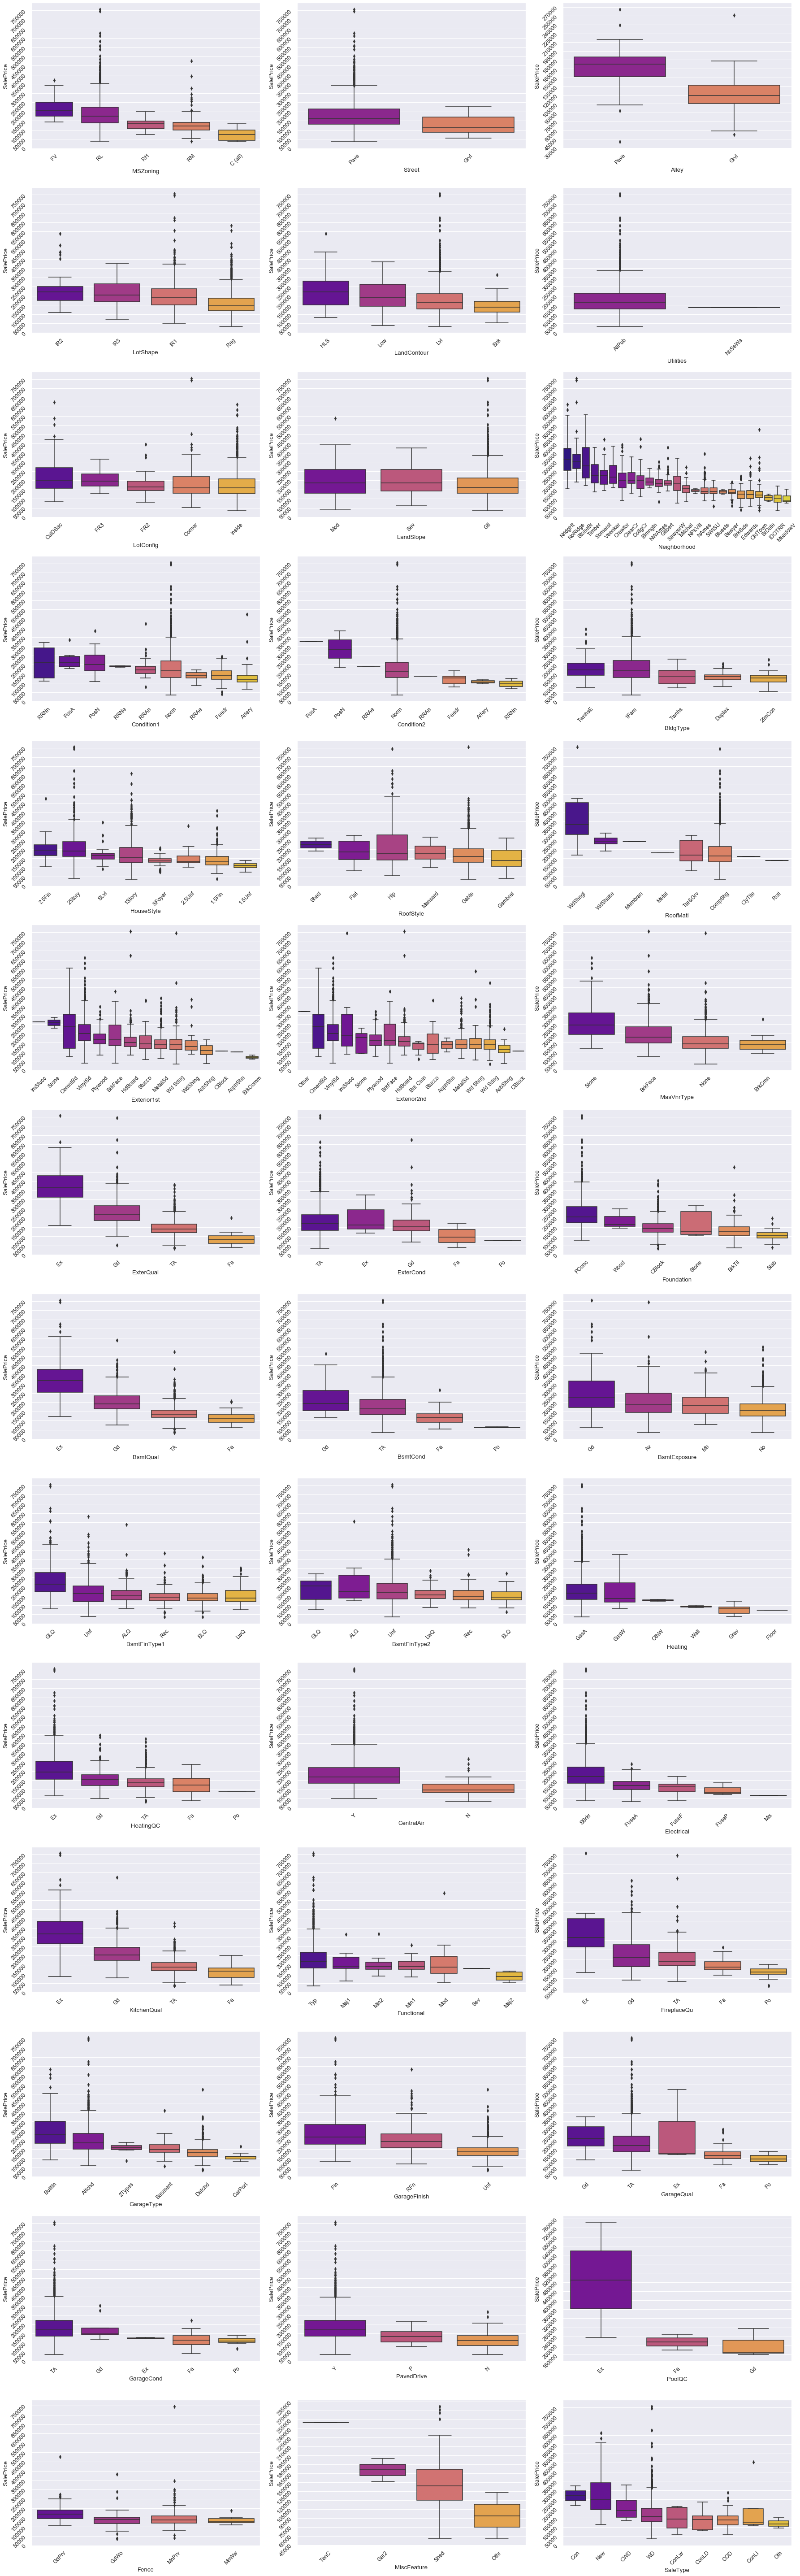

In [98]:
srt_box("SalePrice", train_data)

In [99]:
# Converting some of the categorical values to numeric ones. Choosing similar values for closer groups to balance linear relations...

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}

features['Neighborhood'] = features['Neighborhood'].map(neigh_map).astype(
    'int')
ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')
features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [24]:
# Dealing Categorical Values

# Neighbourhood
neigh_map = np.floor(train_data.groupby("Neighborhood")["SalePrice"].median().sort_values()/20000)-3

features["Neighborhood"] = features["Neighborhood"].map(neigh_map).astype("int")

In [62]:
# ExterQual
ext_map = np.floor(train_data.groupby("ExterQual")["SalePrice"].median().sort_values()/100000) + 1

features["ExterQual"] = features["ExterQual"].map(ext_map)

In [65]:
# ExterCond
ext_cond_map = np.ceil(train_data.groupby("ExterCond")["SalePrice"].median().sort_values()/10000 - 7)

features["ExterCond"] = features["ExterCond"].map(ext_cond_map)

In [75]:
# BsmtQual
bsmt_qual_map = np.round(train_data.groupby("BsmtQual")["SalePrice"].median().sort_values()/100000)
features["BsmtQual"] = features["BsmtQual"].map(bsmt_qual_map)

# BsmtCond
bsmt_cond_map = np.round(train_data.groupby("BsmtCond")["SalePrice"].median().sort_values()/100000)
features["BsmtCond"] = features["BsmtCond"].map(bsmt_cond_map)

In [83]:
# BsmtFinType1
bsmf1_map = np.round(train_data.groupby("BsmtFinType1")["SalePrice"].median().sort_values()/100000)
features["BsmtFinType1"] = features["BsmtFinType1"].map(bsmf1_map)

# BsmtFinType2
bsmf2_map = np.round(train_data.groupby("BsmtFinType2")["SalePrice"].median().sort_values()/100000)
features["BsmtFinType2"] = features["BsmtFinType2"].map(bsmf2_map)

In [85]:
# HeatingQC
train_data.groupby("BsmtFinType1")["SalePrice"].median().sort_values()

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   int32  
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [73]:
# Converting some of the categorical values to numeric ones. Choosing similar values for closer groups to balance linear relations...

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}

features['Neighborhood'] = features['Neighborhood'].map(neigh_map).astype(
    'int')
ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')
features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')

ValueError: Cannot convert non-finite values (NA or inf) to integer

# Numeric Data

In [74]:
# Plotting numerical features with polynomial order to detect outliers by eye.

def srt_reg(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()